# Imports

In [1]:
!pip install epiweeks -q
!pip install torch_geometric -q

In [2]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from epiweeks import Week, Year
import pandas as pd
global N
import os
dtype = torch.float
WEEKS_AHEAD = 4
PAD_VALUE = -999
DAYS_IN_WEEK = 7
NOISE_LEVELS_FLU = [0.15, 0.25, 0.50, 0.75]
NOISE_LEVELS_COVID = [0.5, 1.0, 1.5, 2.0]
# daily death data
""" County and State Data Processing network"""
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import numpy as np
import pdb
import math
import pandas as pd
import os
import yaml
import seaborn as sns
"""For training experiments: freeze values of all params except R0"""
""" Added with sparse logic """
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from abc import ABC, abstractmethod
from scipy.stats import gamma
import math
import torch.nn.functional as F
import yaml
INITIAL_INFECTED_RATIO = 0.5
INFINITY_TIME = np.inf  # really large value outside the bounds of simulation steps
USE_SPARSE = False
import random
import numpy as np
import torch.nn as nn
import time
from torch.autograd import Variable
from copy import copy
import matplotlib.pyplot as plt
import pdb
from epiweeks import Week
import argparse
import numpy as np
import traceback
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Utils

In [16]:
datapath = "/kaggle/input/gradabmdata/Data/Processed/covid_data.csv"
county_datapath = f"/kaggle/input/gradabmdata/Data/Processed/county_data.csv"
datapath_flu_hhs = "/kaggle/input/gradabmdata/Data/Processed/flu_region_data.csv"
datapath_flu_state = "/kaggle/input/gradabmdata/Data/Processed/flu_state_data.csv"
population_path = "/kaggle/input/gradabmdata/Data/ABM_parameters/table_population.csv"
EW_START_DATA = "202012"
EW_START_DATA_FLU = "201740"  # for convenience

# Select signals COVID
macro_features = [
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline",
    "apple_mobility",
    "death_jhu_incidence",
    "positiveIncr",
]

# Select signals Flu
include_cols = [
    "symptom:Fever",
    "symptom:Low-grade fever",
    "symptom:Cough",
    "symptom:Sore throat",
    "symptom:Headache",
    "symptom:Fatigue",
    "symptom:Vomiting",
    "symptom:Diarrhea",
    "symptom:Shortness of breath",
    "symptom:Chest pain",
    "symptom:Dizziness",
    "symptom:Confusion",
    "symptom:Generalized tonic–clonic seizure",
    "symptom:Weakness",
]

states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "DC",
    "FL",
    "GA",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
    "X",
]

counties = {
    "MA": [
        "25003",
#         "25005",
        "25009",
        "25011",
        "25013",
        "25015",
        "25021",
        "25023",
        "25027",
    ]
}

########################################################
#           helpers
########################################################


def convert_to_epiweek(x):
    return Week.fromstring(str(x))


def get_epiweeks_list(start_ew, end_ew):
    """
    returns list of epiweeks objects between start_ew and end_ew (inclusive)
    this is useful for iterating through these weeks
    """
    if type(start_ew) == str:
        start_ew = convert_to_epiweek(start_ew)
    if type(end_ew) == str:
        end_ew = convert_to_epiweek(end_ew)
    iter_weeks = (
        list(Year(2017).iterweeks())
        + list(Year(2018).iterweeks())
        + list(Year(2019).iterweeks())
        + list(Year(2020).iterweeks())
        + list(Year(2021).iterweeks())
    )
    idx_start = iter_weeks.index(start_ew)
    idx_end = iter_weeks.index(end_ew)
    return iter_weeks[idx_start : idx_end + 1]


def create_window_seqs(
    X: np.ndarray,
    y: np.ndarray,
    min_sequence_length: int,
):
    """
    Creates windows of fixed size with appended zeros
    @param X: features
    @param y: targets, in synchrony with features (i.e. x[t] and y[t] correspond to the same time)
    """
    # convert to small sequences for training, starting with length 10
    seqs = []
    targets = []
    mask_ys = []

    # starts at sequence_length and goes until the end
    # for idx in range(min_sequence_length, X.shape[0]+1, 7): # last in range is step
    for idx in range(min_sequence_length, X.shape[0] + 1, 1):
        # Sequences
        seqs.append(torch.from_numpy(X[:idx, :]))
        # Targets
        y_ = y[:idx]
        mask_y = torch.ones(len(y_))
        targets.append(torch.from_numpy(y_))
        mask_ys.append(mask_y)
    seqs = pad_sequence(seqs, batch_first=True, padding_value=0).type(dtype)
    ys = pad_sequence(targets, batch_first=True, padding_value=PAD_VALUE).type(dtype)
    mask_ys = pad_sequence(mask_ys, batch_first=True, padding_value=0).type(dtype)

    return seqs, ys, mask_ys

########################################################
#           COVID: state/national level data
########################################################


def load_df(region, ew_start_data, ew_end_data):
    """load and clean data"""
    df = pd.read_csv(datapath, low_memory=False)
    df = df[(df["region"] == region)]
    df["epiweek"] = df.loc[:, "epiweek"].apply(convert_to_epiweek)
    # subset data using init parameters
    df = df[(df["epiweek"] <= ew_end_data) & (df["epiweek"] >= ew_start_data)]
    df = df.fillna(method="ffill")
    df = df.fillna(method="backfill")
    df = df.fillna(0)
    return df


def get_state_train_data(region, pred_week, ew_start_data=EW_START_DATA):
    """get processed dataframe of data + target as array"""
    # import data
    region = str.upper(region)
    pred_week = convert_to_epiweek(pred_week)
    ew_start_data = convert_to_epiweek(ew_start_data)
    df = load_df(region, ew_start_data, pred_week)
    # select targets
    # targets = df.loc[:,['positiveIncr','death_jhu_incidence']].values
    targets = df.loc[:, ["positiveIncr"]].values
    # now subset based on input ew_start_data
    df = df[macro_features]
    return df, targets


def get_state_test_data(region, pred_week):
    """
    @ param pred_week: prediction week
    """
    pred_week = convert_to_epiweek(pred_week)
    # import smoothed dataframe
    df = load_df(region, pred_week + 1, pred_week + 4)
    new_cases = df.loc[:, "positiveIncr"].values
    new_deaths = df.loc[:, "death_jhu_incidence"].values
    return new_cases, new_deaths


def get_train_targets_all_regions(pred_week):
    deaths_all_regions = {}
    for region in states:
        _, targets = get_state_train_data(region, pred_week)
        deaths_all_regions[region] = targets[:, 1]  # index 1 is inc deaths
    return deaths_all_regions


def get_train_features_all_regions(pred_week):
    features_all_regions = {}
    for region in states:
        df, _ = get_state_train_data(region, pred_week)
        features_all_regions[region] = df.to_numpy()
    return features_all_regions


########################################################
#           COVID: county level data
# note: to obtain data, use get_features_per_county.ipynb
########################################################


def load_county_df(county, ew_start_data, ew_end_data):
    """load and clean data"""
    df = pd.read_csv(county_datapath)
    df = df[(df["geo_value"] == int(county))]
    from datetime import datetime
    from datetime import date

    def convert_date_to_epiweek(x):
        if isinstance(x, Week):
            return x
        else:
            date = datetime.strptime(x, "%Y-%m-%d")
            return Week.fromdate(date)

    df["epiweek"] = df.loc[:, "time_value"].apply(convert_date_to_epiweek)    
    # subset data using init parameters
    df = df[(df["epiweek"] <= ew_end_data) & (df["epiweek"] >= ew_start_data)]
    df = df.fillna(0)  # there are zeros at the beginning
    return df


def get_county_train_data(
    county, pred_week, ew_start_data=EW_START_DATA, noise_level=0
):
    # import data
    pred_week = convert_to_epiweek(pred_week)
    ew_start_data = convert_to_epiweek(ew_start_data)
    df = load_county_df(county, ew_start_data, pred_week)
    # select targets
    targets = df.loc[:, ["cases", "deaths"]].values
    if noise_level > 0:
        # noise_level is an index for your list
        noise = NOISE_LEVELS_COVID[noise_level - 1]
        std_vals = np.std(targets, axis=0) * noise
        noise_dist = np.random.normal(scale=std_vals, size=targets.shape)
        noisy_targets = targets + noise_dist
        noisy_targets = noisy_targets.astype("int32")
        targets = np.maximum(noisy_targets, 0)
    df.drop(columns=["epiweek", "geo_value", "time_value"], inplace=True)
    return df, targets


def get_county_test_data(county, pred_week):
    """
    @ param pred_week: prediction week
    """
    pred_week = convert_to_epiweek(pred_week)
    # import smoothed dataframe
    df = load_county_df(county, pred_week, pred_week + 4)
    new_cases = df.loc[:, "cases"].values
    new_deaths = df.loc[:, "deaths"].values
    return new_cases, new_deaths


########################################################
#           FLU: regional/state/national level data
########################################################


def load_df_flu(region, ew_start_data, ew_end_data, geo):
    """load and clean data"""
    if geo == "hhs":
        datapath = datapath_flu_hhs
    elif geo == "state":
        datapath = datapath_flu_state
    else:
        raise ValueError("geo must be hhs or state")
    df = pd.read_csv(datapath, low_memory=False)

    df = df[(df["region"] == region)]
    df["epiweek"] = df.loc[:, "epiweek"].apply(convert_to_epiweek)
    # subset data using init parameters
    df = df[(df["epiweek"] <= ew_end_data) & (df["epiweek"] >= ew_start_data)]
    df = df.fillna(method="ffill")
    df = df.fillna(method="backfill")
    df = df.fillna(0)
    return df


def get_state_train_data_flu(
    region, pred_week, ew_start_data=EW_START_DATA_FLU, geo="state", noise_level=0
):
    """get processed dataframe of data + target as array"""
    # import data
    region = str.upper(region)
    pred_week = convert_to_epiweek(pred_week)
    ew_start_data = convert_to_epiweek(ew_start_data)
    df = load_df_flu(region, ew_start_data, pred_week, geo)
    # select targets
    # targets = df["ili"].astype(float).values.reshape(-1, 1) 
    targets = df["ili"].astype(float).values.reshape(-1,1) # we need this 2d
    if noise_level > 0:
        # noise_level is an index for your list
        noise = NOISE_LEVELS_FLU[noise_level - 1]
        NOISE_STD = targets.std() * noise
        noise_dist = np.random.normal(loc=0, scale=NOISE_STD, size=targets.shape)
        noisy_targets = targets + noise_dist
        targets = np.array([max(ix, 0) for ix in noisy_targets])
    # now subset based on input ew_start_data
    df = df[["month"] + include_cols]
    return df, targets


def get_state_test_data_flu(region, pred_week, geo="state"):
    """
    @ param pred_week: prediction week
    """
    pred_week = convert_to_epiweek(pred_week)
    # import smoothed dataframe
    df = load_df_flu(region, pred_week + 1, pred_week + 4, geo)
    ili = df.loc[:, "ili"].values
    return ili


def get_dir_from_path_list(path):
    outdir = path[0]
    if not (os.path.exists(outdir)):
        os.makedirs(outdir)
    for p in path[1:]:
        outdir = os.path.join(outdir, p)
        if not (os.path.exists(outdir)):
            os.makedirs(outdir)
    return outdir

# Model Utils

In [92]:
cuda = torch.device("cuda")
dtype = torch.float
SMOOTH_WINDOW = 7

class TransformerAttn(nn.Module):
    """
    Module that calculates self-attention weights using transformer like attention
    """

    def __init__(self, dim_in=40, value_dim=40, key_dim=40) -> None:
        """
        param dim_in: Dimensionality of input sequence
        param value_dim: Dimension of value transform
        param key_dim: Dimension of key transform
        """
        super(TransformerAttn, self).__init__()
        self.value_layer = nn.Linear(dim_in, value_dim)
        self.query_layer = nn.Linear(dim_in, value_dim)
        self.key_layer = nn.Linear(dim_in, key_dim)

    def forward(self, seq):
        """
        param seq: Sequence in dimension [Seq len, Batch, Hidden size]
        """
        seq_in = seq.transpose(0, 1)
        value = self.value_layer(seq_in)
        query = self.query_layer(seq_in)
        keys = self.key_layer(seq_in)
        weights = (value @ query.transpose(1, 2)) / math.sqrt(seq.shape[-1])
        weights = torch.softmax(weights, -1)
        return (weights @ keys).transpose(1, 0)

    def forward_mask(self, seq, mask):
        """
        param seq: Sequence in dimension [Seq len, Batch, Hidden size]
        """
        seq_in = seq.transpose(0, 1)
        value = self.value_layer(seq_in)
        query = self.query_layer(seq_in)
        keys = self.key_layer(seq_in)
        weights = (value @ query.transpose(1, 2)) / math.sqrt(seq.shape[-1])
        weights = torch.exp(weights)
        weights = (weights.transpose(1, 2) * mask.transpose(1, 0)).transpose(1, 2)
        weights = weights / (weights.sum(-1, keepdim=True))
        return (weights @ keys).transpose(1, 0) * mask


class EmbedAttenSeq(nn.Module):
    def __init__(
        self,
        dim_seq_in: int = 5,
        dim_metadata: int = 3,
        rnn_out: int = 40,
        dim_out: int = 50,
        n_layers: int = 1,
        bidirectional: bool = False,
        attn=TransformerAttn,
        dropout=0.0,
        rnn_type='LSTM',  # Add rnn_type parameter
    ) -> None:
        super(EmbedAttenSeq, self).__init__()

        self.dim_seq_in = dim_seq_in
        self.dim_metadata = dim_metadata
        self.rnn_out = rnn_out
        self.dim_out = dim_out
        self.bidirectional = bidirectional

        # Choose between LSTM and GRU based on rnn_type
        rnn_layer = nn.LSTM if rnn_type == 'LSTM' else nn.GRU

        self.rnn = rnn_layer(
            input_size=self.dim_seq_in,
            hidden_size=self.rnn_out // 2 if self.bidirectional else self.rnn_out,
            bidirectional=bidirectional,
            num_layers=n_layers,
            dropout=dropout,
        )
        self.attn_layer = attn(self.rnn_out, self.rnn_out, self.rnn_out)
        self.layer_norm = nn.LayerNorm(self.rnn_out)  # Add Layer Normalization
        self.out_layer = [
            nn.Linear(
                in_features=self.rnn_out + self.dim_metadata, out_features=self.dim_out
            ),
            nn.Tanh(),
            nn.Dropout(dropout),
        ]
        self.out_layer = nn.Sequential(*self.out_layer)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.out_layer.apply(init_weights)

    def forward_mask(self, seqs, metadata, mask):
        # Take last output from GRU or LSTM
        latent_seqs = self.rnn(seqs)[0]
        latent_seqs = self.attn_layer.forward_mask(latent_seqs, mask)
        latent_seqs = self.layer_norm(latent_seqs.sum(0))  # Apply layer Normalization
        out = self.out_layer(torch.cat([latent_seqs, metadata], dim=1))
        return out

    def forward(self, seqs, metadata):
        # Take last output from GRU or LSTM
        latent_seqs, encoder_hidden = self.rnn(seqs)
        latent_seqs = self.attn_layer(latent_seqs)
        latent_seqs = self.layer_norm(latent_seqs.sum(0))  # Apply layer Normalization
        out = self.out_layer(torch.cat([latent_seqs, metadata], dim=1))
        return out, encoder_hidden


class DecodeSeq(nn.Module):
    def __init__(
        self,
        dim_seq_in: int = 5,
        dim_metadata: int = 3,
        rnn_out: int = 40,
        dim_out: int = 5,
        n_layers: int = 1,
        bidirectional: bool = False,
        dropout=0.0,
        rnn_type='LSTM',  # Add rnn_type parameter
    ) -> None:
        super(DecodeSeq, self).__init__()

        self.dim_seq_in = dim_seq_in
        self.dim_metadata = dim_metadata
        self.rnn_out = rnn_out
        self.dim_out = dim_out
        self.bidirectional = bidirectional

        self.act_fcn = nn.Tanh()

        # to embed input
        self.embed_input = nn.Linear(self.dim_seq_in, self.rnn_out)

        # to combine input and context
        self.attn_combine = nn.Linear(2 * self.rnn_out, self.rnn_out)

        # Choose between LSTM and GRU based on rnn_type
        rnn_layer = nn.LSTM if rnn_type == 'LSTM' else nn.GRU

        self.rnn = rnn_layer(
            input_size=self.rnn_out,
            hidden_size=self.rnn_out // 2 if self.bidirectional else self.rnn_out,
            bidirectional=bidirectional,
            num_layers=n_layers,
            dropout=dropout,
        )
        self.out_layer = [
            nn.Linear(in_features=self.rnn_out, out_features=self.dim_out),
            nn.Tanh(),
            nn.Dropout(dropout),
        ]
        self.out_layer = nn.Sequential(*self.out_layer)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.out_layer.apply(init_weights)
        self.embed_input.apply(init_weights)
        self.attn_combine.apply(init_weights)

    def forward(self, Hi_data, encoder_hidden, context):
        # Hi_data is scaled time
        inputs = Hi_data.transpose(1, 0)

        # Calculate the number of directions (1 for unidirectional, 2 for bidirectional)
        num_directions = 2 if self.bidirectional else 1

        # Initialize the hidden state and cell state with the correct dimensions
        h0 = torch.zeros(num_directions, inputs.size(1), self.rnn_out // num_directions)
        c0 = torch.zeros(num_directions, inputs.size(1), self.rnn_out // num_directions)

        # Combine input and context
        inputs = self.embed_input(inputs)
        # Repeat context for each item in sequence
        context = context.repeat(inputs.shape[0], 1, 1)
        inputs = torch.cat((inputs, context), 2)
        inputs = self.attn_combine(inputs)
        
        inputs = inputs.to("cuda:0")
        h0 = h0.to("cuda:0")
        c0 = c0.to("cuda:0")
        # Take last output from LSTM
        if isinstance(self.rnn, nn.LSTM):
            latent_seqs, _ = self.rnn(inputs, (h0, c0))
        else:
            latent_seqs, _ = self.rnn(inputs, h0)
        latent_seqs = latent_seqs.transpose(1, 0)
        latent_seqs = self.out_layer(latent_seqs)
        return latent_seqs



""" smooth data with moving average (common with fitting mechanistic models) """

def moving_average(x, w):
    return pd.Series(x).rolling(w, min_periods=1).mean().values


""" Specify which state """


def fetch_county_data_covid(
    state="MA", county_id="25005", pred_week="202021", batch_size=32, noise_level=0
):
    """Import COVID data for counties"""
    np.random.seed(17)

    if county_id == "all":
        all_counties = counties[state]
    else:
        all_counties = [county_id]

    c_seqs = []  # county sequences of features
    c_ys = []  # county targets
    for county in all_counties:
        X_county, y = get_county_train_data(county, pred_week, noise_level=noise_level)
        y = moving_average(y[:, 1].ravel(), SMOOTH_WINDOW).reshape(-1, 1)
        c_seqs.append(X_county.to_numpy())
        c_ys.append(y)
    c_seqs = np.array(c_seqs)  # Shape: [regions, time, features]
    c_ys = np.array(c_ys)  # Shape: [regions, time, 1]

    # Normalize
    # One scaler per county
    scalers = [StandardScaler() for _ in range(len(all_counties))]
    c_seqs_norm = []
    for i, scaler in enumerate(scalers):
        c_seqs_norm.append(scaler.fit_transform(c_seqs[i]))
    c_seqs_norm = np.array(c_seqs_norm)

    """ Create static metadata data for each county """

    county_idx = {r: i for i, r in enumerate(all_counties)}

    def one_hot(idx, dim=len(county_idx)):
        ans = np.zeros(dim, dtype="float32")
        ans[idx] = 1.0
        return ans

    metadata = np.array([one_hot(county_idx[r]) for r in all_counties])

    """ Prepare train and validation dataset """

    min_sequence_length = 20
    metas, seqs, y, y_mask = [], [], [], []
    for meta, seq, ys in zip(metadata, c_seqs_norm, c_ys):
        seq, ys, ys_mask = create_window_seqs(seq, ys, min_sequence_length)
        metas.append(meta)
        seqs.append(seq[[-1]])
        y.append(ys[[-1]])
        y_mask.append(ys_mask[[-1]])

    all_metas = np.array(metas, dtype="float32")
    all_county_seqs = torch.cat(seqs, axis=0)
    all_county_ys = torch.cat(y, axis=0)
    all_county_y_mask = torch.cat(y_mask, axis=0)

    counties_train, metas_train, X_train, y_train, y_mask_train = (
        all_counties,
        all_metas,
        all_county_seqs,
        all_county_ys,
        all_county_y_mask,
    )

    train_dataset = SeqData(counties_train, metas_train, X_train, y_train, y_mask_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    assert all_county_seqs.shape[1] == all_county_ys.shape[1]
    seqlen = all_county_seqs.shape[1]
    return train_loader, metas_train.shape[1], X_train.shape[2], seqlen


def fetch_county_data_flu(
    state="MA", county_id="25005", pred_week="202021", batch_size=32, noise_level=0
):
    """in flu, our features are state-level and target ILI is only available at state"""
    np.random.seed(17)

    """ Import data for all counties """

    if county_id == "all":
        all_counties = counties[state]
    else:
        all_counties = [county_id]

    X_state, y = get_state_train_data_flu(state, pred_week, noise_level=noise_level)
    y = moving_average(y.ravel(), SMOOTH_WINDOW).reshape(-1, 1)
    c_seqs = []  # county sequences of features
    c_ys = []  # county targets
    for _ in all_counties:
        c_seqs.append(X_state.to_numpy())
        c_ys.append(y)
    c_seqs = np.array(c_seqs)  # Shape: [regions, time, features]
    c_ys = np.array(c_ys)  # Shape: [regions, time, 1]

    # Normalize
    # One scaler per county
    scalers = [StandardScaler() for _ in range(len(all_counties))]
    c_seqs_norm = []
    for i, scaler in enumerate(scalers):
        c_seqs_norm.append(scaler.fit_transform(c_seqs[i]))
    c_seqs_norm = np.array(c_seqs_norm)

    """ Create static metadata data for each county """

    county_idx = {r: i for i, r in enumerate(all_counties)}

    def one_hot(idx, dim=len(county_idx)):
        ans = np.zeros(dim, dtype="float32")
        ans[idx] = 1.0
        return ans

    metadata = np.array([one_hot(county_idx[r]) for r in all_counties])

    """ Prepare train and validation dataset """
    min_sequence_length = 5
    metas, seqs, y, y_mask = [], [], [], []
    for meta, seq, ys in zip(metadata, c_seqs_norm, c_ys):
        seq, ys, ys_mask = create_window_seqs(seq, ys, min_sequence_length)
        metas.append(meta)
        seqs.append(seq[[-1]])
        y.append(ys[[-1]])
        y_mask.append(ys_mask[[-1]])

    all_metas = np.array(metas, dtype="float32")
    all_county_seqs = torch.cat(seqs, axis=0)
    all_county_ys = torch.cat(y, axis=0)
    all_county_y_mask = torch.cat(y_mask, axis=0)

    counties_train, metas_train, X_train, y_train, y_mask_train = (
        all_counties,
        all_metas,
        all_county_seqs,
        all_county_ys,
        all_county_y_mask,
    )
    train_dataset = SeqData(counties_train, metas_train, X_train, y_train, y_mask_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    assert all_county_seqs.shape[1] == all_county_ys.shape[1]
    seqlen = all_county_seqs.shape[1]

    return train_loader, metas_train.shape[1], X_train.shape[2], seqlen


# dataset class
class SeqData(torch.utils.data.Dataset):
    def __init__(self, region, meta, X, y, mask_y):
        self.region = region
        self.meta = meta
        self.X = X
        self.y = y
        # self.mask_y = mask_y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (self.region[idx], self.meta[idx], self.X[idx, :, :], self.y[idx])


class ODE(nn.Module):
    def __init__(self, params, device):
        super(ODE, self).__init__()
        county_id = params["county_id"]
        abm_params = f"/kaggle/input/gradabmdata/Data/{county_id}_generated_params.yaml"
        # Reading params
        with open(abm_params, "r") as stream:
            try:
                abm_params = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print("Error in reading parameters file")
                print(exc)
        params.update(abm_params)
        self.params = params
        self.device = device
        self.num_agents = self.params["num_agents"]  # Population


class SEIRM(ODE):
    def __init__(self, params, device):
        super().__init__(params, device)

    def init_compartments(self, learnable_params):
        """let's get initial conditions"""
        initial_infections_percentage = learnable_params[
            "initial_infections_percentage"
        ]
        initial_conditions = torch.empty((5)).to(self.device)
        no_infected = (
            initial_infections_percentage / 100
        ) * self.num_agents  # 1.0 is ILI
        initial_conditions[2] = no_infected
        initial_conditions[0] = self.num_agents - no_infected
        print("initial infected", no_infected)
        self.state = initial_conditions

    def step(self, t, values):
        """
        Computes ODE states via equations
            state is the array of state value (S,E,I,R,M)
        """
        params = {
            "beta": values[0],
            "alpha": values[1],
            "gamma": values[2],
            "mu": values[3],
            "initial_infections_percentage": values[4],
        }
        if t == 0:
            self.init_compartments(params)
        # to make the NN predict lower numbers, we can make its prediction to be N-Susceptible
        dSE = params["beta"] * self.state[0] * self.state[2] / self.num_agents
        dEI = params["alpha"] * self.state[1]
        dIR = params["gamma"] * self.state[2]
        dIM = params["mu"] * self.state[2]

        dS = -1.0 * dSE
        dE = dSE - dEI
        dI = dEI - dIR - dIM
        dR = dIR
        dM = dIM

        # concat and reshape to make it rows as obs, cols as states
        self.dstate = torch.stack([dS, dE, dI, dR, dM], 0)
        NEW_INFECTIONS_TODAY = dEI
        NEW_DEATHS_TODAY = dIM
        # update state
        self.state = self.state + self.dstate

        return NEW_INFECTIONS_TODAY, NEW_DEATHS_TODAY


class SIRS(ODE):
    def __init__(self, params, device):
        super().__init__(params, device)

    def init_compartments(self, learnable_params):
        """let's get initial conditions"""
        initial_infections_percentage = learnable_params[
            "initial_infections_percentage"
        ]
        initial_conditions = torch.empty((2)).to(self.device)
        no_infected = (
            initial_infections_percentage / 100
        ) * self.num_agents  # 1.0 is ILI
        initial_conditions[1] = no_infected
        initial_conditions[0] = self.num_agents - no_infected
        print("initial infected", no_infected)

        self.state = initial_conditions

    def step(self, t, values):
        """
        Computes ODE states via equations
            state is the array of state value (S,I)
        """
        params = {
            "beta": values[0],  # contact rate, range: 0-1
            "initial_infections_percentage": values[1],
        }
        # set from expertise
        params["D"] = 3.5
        params["L"] = 2000
        if t == 0:
            self.init_compartments(params)
        dS = (self.num_agents - self.state[0] - self.state[1]) / params["L"] - params[
            "beta"
        ] * self.state[0] * self.state[1] / self.num_agents
        dSI = params["beta"] * self.state[0] * self.state[1] / self.num_agents
        dI = dSI - self.state[1] / params["D"]

        # concat and reshape to make it rows as obs, cols as states
        self.dstate = torch.stack([dS, dI], 0)

        NEW_INFECTIONS_TODAY = dSI
        # ILI is percentage of outpatients with influenza-like illness
        # ILI = params['lambda'] * dSI / self.num_agents
        # this is what Shaman and Pei do https://github.com/SenPei-CU/Multi-Pathogen_ILI_Forecast/blob/master/code/SIRS_AH.m
        ILI = dSI / self.num_agents * 100  # multiply 100 because it is percentage

        # update state
        self.state = self.state + self.dstate
        return NEW_INFECTIONS_TODAY, ILI

# Abm-model

In [93]:
INITIAL_INFECTED_RATIO = 0.5
INFINITY_TIME = np.inf  # really large value outside the bounds of simulation steps
USE_SPARSE = False
"""Utility Modules"""

class LogitRelaxedBernoulli(object):
    def __init__(self, logits, temperature=0.3, **kwargs):
        self.logits = logits
        self.temperature = temperature

    def rsample(self):
        eps = torch.clamp(
            torch.rand(
                self.logits.size(), dtype=self.logits.dtype, device=self.logits.device
            ),
            min=1e-6,
            max=1 - 1e-6,
        )
        y = (self.logits + torch.log(eps) - torch.log(1.0 - eps)) / self.temperature
        return y

    def log_prob(self, value):
        return (
            math.log(self.temperature)
            - self.temperature * value
            + self.logits
            - 2 * F.softplus(-self.temperature * value + self.logits)
        )


def lam(x_i, x_j, edge_attr, t, R, SFSusceptibility, SFInfector, lam_gamma_integrals):
    """
    x_i and x_j are attributes from nodes for all edges in the graph
        note: x_j[:, 2].sum() will be higher than current infections because there are some nodes repeated
    """
    S_A_s = SFSusceptibility[x_i[:, 0].long()]
    A_s_i = SFInfector[x_j[:, 1].long()]
    B_n = edge_attr[1, :]
    integrals = torch.zeros_like(B_n)
    infected_idx = x_j[:, 2].bool()
    infected_times = t - x_j[infected_idx, 3]

    integrals[infected_idx] = lam_gamma_integrals[
        infected_times.long()
    ]  #:,2 is infected index and :,3 is infected time
    edge_network_numbers = edge_attr[
        0, :
    ]  # to account for the fact that mean interactions start at 4th position of x
    I_bar = torch.gather(x_i[:, 4:27], 1, edge_network_numbers.view(-1, 1).long()).view(
        -1
    )  # to account for the fact that mean interactions start at 4th position of x
    res = R * S_A_s * A_s_i * B_n * integrals / I_bar  # Edge attribute 1 is B_n

    return res.view(-1, 1)


class InfectionNetwork(MessagePassing):
    """Contact network with graph message passing function for disease spread"""

    def __init__(
        self, lam, R, SFSusceptibility, SFInfector, lam_gamma_integrals, device
    ):
        super(InfectionNetwork, self).__init__(aggr="add")
        self.lam = lam
        self.R = R
        self.SFSusceptibility = SFSusceptibility
        self.SFInfector = SFInfector
        self.lam_gamma_integrals = lam_gamma_integrals
        self.device = device

    def forward_sparse(self, data, r0_value_trainable):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        t = data.t
        # sparse adjacency matrix of inter-agent interactions
        S_A_s = self.SFSusceptibility[x[:, 0].long()]
        A_s_i = self.SFInfector[x[:, 1].long()]
        integrals = torch.zeros_like(S_A_s)
        infected_idx = x[:, 2].bool()
        infected_times = t - x[infected_idx, 3]
        integrals[infected_idx] = self.lam_gamma_integrals[
            infected_times.long()
        ]  #:,2 is infected index and :,3 is infected time
        I_bar = x[:, 4 + 22]  # only info for random network being used in current expts
        integral_asi = A_s_i * integrals
        sparse_adj = torch.sparse_coo_tensor.from_indices_and_values(
            indices=[edge_index[0], edge_index[1]],
            values=torch.ones(edge_index.shape[1]),
            size=(x.shape[0], x.shape[0]),
        ).to(self.device)
        sparse_asi = integral_asi.view(-1, 1).to_sparse().to(self.device)
        sparse_mult = torch.sparse.mm(sparse_adj, sparse_asi)
        dense_mult = sparse_mult.to_dense().view(-1)

        # total infection
        infection_transmission = (
            r0_value_trainable * S_A_s * dense_mult
        ) / I_bar  # /I_bar
        return infection_transmission.view(1, -1)

    def forward(self, data, r0_value_trainable):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        t = data.t
        return self.propagate(
            edge_index,
            x=x,
            edge_attr=edge_attr,
            t=t,
            R=r0_value_trainable,
            SFSusceptibility=self.SFSusceptibility,
            SFInfector=self.SFInfector,
            lam_gamma_integrals=self.lam_gamma_integrals,
        )

    def message(
        self,
        x_i,
        x_j,
        edge_attr,
        t,
        R,
        SFSusceptibility,
        SFInfector,
        lam_gamma_integrals,
    ):
        # x_j has shape [E, in_channels]
        tmp = self.lam(
            x_i, x_j, edge_attr, t, R, SFSusceptibility, SFInfector, lam_gamma_integrals
        )  # tmp has shape [E, 2 * in_channels]
        return tmp


class DiseaseProgression(ABC):
    """abstract class"""

    def __init__(self):
        pass

    @abstractmethod
    def initialize_variables(self):
        """initialize tensor variables depending on disease"""
        pass

    @abstractmethod
    def update_next_stage_times(self):
        """update time"""
        pass

    @abstractmethod
    def update_current_stage(self):
        """update stage"""
        pass


class SEIRMProgression(DiseaseProgression):
    """SEIRM for COVID-19"""

    def __init__(self, params):
        super(DiseaseProgression, self).__init__()
        # encoding of stages
        self.SUSCEPTIBLE_VAR = 0
        self.EXPOSED_VAR = 1  # exposed state
        self.INFECTED_VAR = 2
        self.RECOVERED_VAR = 3
        self.MORTALITY_VAR = 4
        # default times (only for initialization, later they are learned)
        self.EXPOSED_TO_INFECTED_TIME = 3
        self.INFECTED_TO_RECOVERED_TIME = 5
        # inf time
        self.INFINITY_TIME = params["num_steps"] + 1
        self.num_agents = params["num_agents"]

    def initialize_variables(
        self, agents_infected_time, agents_stages, agents_next_stage_times
    ):
        """initialize tensor variables depending on disease"""
        # agents in I have been at least a few days infected as they have been previously in exposed
        # assumption that agents in E have been infected 1 day, and agents in I have been infected EXPOSED_TO_INFECTED_TIME days
        agents_infected_time[agents_stages == self.EXPOSED_VAR] = -1
        agents_infected_time[agents_stages == self.INFECTED_VAR] = (
            -1 * self.EXPOSED_TO_INFECTED_TIME
        )
        agents_next_stage_times[
            agents_stages == self.EXPOSED_VAR
        ] = self.EXPOSED_TO_INFECTED_TIME
        agents_next_stage_times[
            agents_stages == self.INFECTED_VAR
        ] = self.INFECTED_TO_RECOVERED_TIME

        return agents_infected_time, agents_next_stage_times

    def update_initial_times(
        self, learnable_params, agents_stages, agents_next_stage_times
    ):
        """this is for the abm constructor"""
        infected_to_recovered_time = learnable_params["infected_to_recovered_time"]
        exposed_to_infected_time = learnable_params["exposed_to_infected_time"]
        agents_next_stage_times[
            agents_stages == self.EXPOSED_VAR
        ] = exposed_to_infected_time
        agents_next_stage_times[
            agents_stages == self.INFECTED_VAR
        ] = infected_to_recovered_time
        return agents_next_stage_times

    def get_newly_exposed(self, current_stages, potentially_exposed_today):
        # we now get the ones that new to exposure
        newly_exposed_today = (
            current_stages == self.SUSCEPTIBLE_VAR
        ) * potentially_exposed_today
        return newly_exposed_today

    def update_next_stage_times(
        self,
        learnable_params,
        newly_exposed_today,
        current_stages,
        agents_next_stage_times,
        t,
    ):
        """update time"""
        exposed_to_infected_time = learnable_params["exposed_to_infected_time"]
        infected_to_recovered_time = learnable_params["infected_to_recovered_time"]
        # for non-exposed
        # if S, R, M -> set to default value; if E/I -> update time if your transition time arrived in the current time
        new_transition_times = torch.clone(agents_next_stage_times)
        curr_stages = torch.clone(current_stages).long()
        new_transition_times[
            (curr_stages == self.INFECTED_VAR) * (agents_next_stage_times == t)
        ] = self.INFINITY_TIME
        new_transition_times[
            (curr_stages == self.EXPOSED_VAR) * (agents_next_stage_times == t)
        ] = (t + infected_to_recovered_time)
        return (
            newly_exposed_today * (t + 1 + exposed_to_infected_time)
            + (1 - newly_exposed_today) * new_transition_times
        )

    def get_target_variables(
        self,
        params,
        learnable_params,
        newly_exposed_today,
        current_stages,
        agents_next_stage_times,
        t,
    ):
        """get recovered (not longer infectious) + targets"""
        mortality_rate = learnable_params["mortality_rate"]
        new_death_recovered_today = (
            current_stages
            * (current_stages == self.INFECTED_VAR)
            * (agents_next_stage_times <= t)
        ) / self.INFECTED_VAR  # agents when stage changes
        # update for newly recovered agents {recovered now}
        recovered_dead_now = new_death_recovered_today  # binary bit vector
        NEW_DEATHS_TODAY = mortality_rate * new_death_recovered_today.sum()
        NEW_INFECTIONS_TODAY = newly_exposed_today.sum()

        return recovered_dead_now, NEW_INFECTIONS_TODAY, NEW_DEATHS_TODAY

    def update_current_stage(
        self, newly_exposed_today, current_stages, agents_next_stage_times, t
    ):
        """progress disease: move agents to different disease stage"""
        transition_to_infected = self.INFECTED_VAR * (
            agents_next_stage_times <= t
        ) + self.EXPOSED_VAR * (agents_next_stage_times > t)
        transition_to_mortality_or_recovered = self.RECOVERED_VAR * (
            agents_next_stage_times <= t
        ) + self.INFECTED_VAR * (
            agents_next_stage_times > t
        )  # can be stochastic --> recovered or mortality

        # Stage progression for agents NOT newly exposed today'''
        # if S -> stay S; if E/I -> see if time to transition has arrived; if R/M -> stay R/M
        stage_progression = (
            (current_stages == self.SUSCEPTIBLE_VAR) * self.SUSCEPTIBLE_VAR
            + (current_stages == self.RECOVERED_VAR) * self.RECOVERED_VAR
            + (current_stages == self.MORTALITY_VAR) * self.MORTALITY_VAR
            + (current_stages == self.EXPOSED_VAR) * transition_to_infected
            + (current_stages == self.INFECTED_VAR)
            * transition_to_mortality_or_recovered
        )

        # update curr stage - if exposed at current step t or not
        current_stages = newly_exposed_today * self.EXPOSED_VAR + stage_progression
        return current_stages

    def init_stages(self, learnable_params, device):
        """initial_infections_percentage should be between 0.1 to 1"""
        initial_infections_percentage = learnable_params[
            "initial_infections_percentage"
        ]
        prob_infected = (initial_infections_percentage / 100) * torch.ones(
            (self.num_agents, 1)
        ).to(device)
        p = torch.hstack((prob_infected, 1 - prob_infected))
        cat_logits = torch.log(p + 1e-9)
        agents_stages = F.gumbel_softmax(logits=cat_logits, tau=1, hard=True, dim=1)[
            :, 0
        ]
        return agents_stages


class SIRSProgression(DiseaseProgression):
    """SIRS for influenza"""

    def __init__(self, params):
        super(DiseaseProgression, self).__init__()
        # encoding of stages
        self.SUSCEPTIBLE_VAR = 0
        self.INFECTED_VAR = 1
        self.RECOVERED_VAR = 2
        # default times (only for initialization, later they are learned)
        self.INFECTED_TO_RECOVERED_TIME = 5
        self.RECOVERED_TO_SUSCEPTIBLE_TIME = 100
        # inf time
        self.INFINITY_TIME = params["num_steps"] + 1
        self.num_agents = params["num_agents"]

    def initialize_variables(
        self, agents_infected_time, agents_stages, agents_next_stage_times
    ):
        """initialize tensor variables depending on disease"""
        agents_infected_time[agents_stages == self.INFECTED_VAR] = -1
        agents_next_stage_times[
            agents_stages == self.INFECTED_VAR
        ] = self.INFECTED_TO_RECOVERED_TIME
        return agents_infected_time, agents_next_stage_times

    def update_initial_times(
        self, learnable_params, agents_stages, agents_next_stage_times
    ):
        infected_to_recovered_time = learnable_params["infected_to_recovered_time"]
        """ this is for the abm constructor """
        agents_next_stage_times[
            agents_stages == self.INFECTED_VAR
        ] = infected_to_recovered_time
        return agents_next_stage_times

    def get_newly_exposed(self, current_stages, potentially_exposed_today):
        # we now get the ones that new to exposure
        newly_exposed_today = (
            current_stages == self.SUSCEPTIBLE_VAR
        ) * potentially_exposed_today
        return newly_exposed_today

    def update_next_stage_times(
        self,
        learnable_params,
        newly_exposed_today,
        current_stages,
        agents_next_stage_times,
        t,
    ):
        """update time"""
        infected_to_recovered_time = learnable_params["infected_to_recovered_time"]
        recovered_to_susceptible_time = learnable_params[
            "recovered_to_susceptible_time"
        ]
        # for non-exposed
        new_transition_times = torch.clone(agents_next_stage_times)
        curr_stages = torch.clone(current_stages).long()
        new_transition_times[
            (curr_stages == self.INFECTED_VAR) * (agents_next_stage_times == t)
        ] = (t + recovered_to_susceptible_time)
        new_transition_times[
            (curr_stages == self.RECOVERED_VAR) * (agents_next_stage_times == t)
        ] = self.INFINITY_TIME  # they go back to susceptible

        return (
            newly_exposed_today * (t + 1 + infected_to_recovered_time)
            + (1 - newly_exposed_today) * new_transition_times
        )

    def get_target_variables(
        self,
        params,
        learnable_params,
        newly_exposed_today,
        current_stages,
        agents_next_stage_times,
        t,
    ):
        """get recovered (not longer infectious) + targets"""
        new_recovered_today = (
            current_stages
            * (current_stages == self.INFECTED_VAR)
            * (agents_next_stage_times <= t)
        ) / self.INFECTED_VAR  # agents when stage changes
        # get ILI
        # ILI =  dSI / self.N * 100 # multiply 100 because it is percentage
        # this is what Shaman and Pei do https://github.com/SenPei-CU/Multi-Pathogen_ILI_Forecast/blob/master/code/SIRS_AH.m
        ILI = newly_exposed_today.sum() / params["num_agents"] * 100
        NEW_INFECTIONS_TODAY = newly_exposed_today.sum()

        return new_recovered_today, NEW_INFECTIONS_TODAY, ILI

    def update_current_stage(
        self, newly_exposed_today, current_stages, agents_next_stage_times, t
    ):
        """progress disease: move agents to different disease stage"""

        transition_to_recovered = self.RECOVERED_VAR * (
            agents_next_stage_times <= t
        ) + self.INFECTED_VAR * (
            agents_next_stage_times > t
        )  # can be stochastic --> recovered or mortality
        transition_to_susceptible = self.SUSCEPTIBLE_VAR * (
            agents_next_stage_times <= t
        ) + self.RECOVERED_VAR * (agents_next_stage_times > t)

        # Stage progression for agents NOT newly exposed today'''
        # if S -> stay S; if E/I -> see if time to transition has arrived; if R/M -> stay R/M
        stage_progression = (
            (current_stages == self.SUSCEPTIBLE_VAR) * self.SUSCEPTIBLE_VAR
            + (current_stages == self.INFECTED_VAR) * transition_to_recovered
            + (current_stages == self.RECOVERED_VAR) * transition_to_susceptible
        )

        current_stages = newly_exposed_today * self.INFECTED_VAR + stage_progression

        return current_stages

    def init_stages(self, learnable_params, device):
        """initial_infections_percentage should be between 0.1 to 1"""

        initial_infections_percentage = learnable_params[
            "initial_infections_percentage"
        ]
        prob_infected = (initial_infections_percentage / 100) * torch.ones(
            (self.num_agents, 1)
        ).to(device)
        p = torch.hstack((prob_infected, 1 - prob_infected))
        cat_logits = torch.log(p + 1e-9)
        agents_stages = F.gumbel_softmax(logits=cat_logits, tau=1, hard=True, dim=1)[
            :, 0
        ]

        return agents_stages


class GradABM:
    def __init__(self, params, device):
        county_id = params["county_id"]
        abm_params = f"/kaggle/input/gradabmdata/Data/ABM_parameters/{county_id}_generated_params.yaml"

        # Reading params
        with open(abm_params, "r") as stream:
            try:
                abm_params = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print("Error in reading parameters file")
                print(exc)
    
        params.update(abm_params)
        params["output_location"]["parent_dir"] = "/kaggle/input/gradabmdata/Data"
        self.params = params
        self.device = device
        self.num_agents = self.params["num_agents"]
        print("Num Agents: ", self.num_agents)

        # **********************************************************************************
        # Environment state variables
        # **********************************************************************************
        # **********************************************************************************
        # Static
        self.agents_ix = (
            torch.arange(0, self.params["num_agents"]).long().to(self.device)
        )
        infile = os.path.join(
            self.params["output_location"]["parent_dir"],
            self.params["output_location"]["agents_dir"],
            self.params["output_location"]["agents_outfile"],
        )

        agents_df = pd.read_csv(infile)
        self.agents_ages = (
            torch.tensor(agents_df["age_group"].to_numpy()).long().to(self.device)
        )  # age constant in simulation

        self.num_networks = 23
        self.network_type_dict = {}
        self.network_type_dict["random"] = 22
        self.network_type_dict_inv = {}
        self.network_type_dict_inv[22] = "random"
        
        params['disease'] = "COVID"
        # select disease progression model
        if params['disease'] == "COVID":
            self.DPM = SEIRMProgression(params)
        elif params['disease'] == "Flu":
            self.DPM = SIRSProgression(params)

        # Age and Network and Occupation may need to be checked to populate this
        self.agents_mean_interactions = 0 * torch.ones(
            self.params["num_agents"], self.num_networks
        ).to(self.device)

        mean_int_ran_df = pd.read_csv("/kaggle/input/gradabmdata/Data/Initialization/RandomNetworkParameters.csv")
        mean_int_ran_mu = (
            torch.tensor(mean_int_ran_df["mu"].values).float().to(self.device)
        )

        child_agents = self.agents_ages <= self.params["CHILD_Upper_Index"]
        adult_agents = torch.logical_and(
            self.agents_ages > self.params["CHILD_Upper_Index"],
            self.agents_ages <= self.params["ADULT_Upper_Index"],
        ).view(-1)
        elderly_agents = self.agents_ages > self.params["ADULT_Upper_Index"]
        self.agents_mean_interactions[child_agents.bool(), 22] = mean_int_ran_mu[0]
        self.agents_mean_interactions[adult_agents.bool(), 22] = mean_int_ran_mu[1]
        self.agents_mean_interactions[elderly_agents.bool(), 22] = mean_int_ran_mu[2]
        self.agents_mean_interactions_split = list(
            torch.split(self.agents_mean_interactions, 1, dim=1)
        )
        self.agents_mean_interactions_split = [
            a.view(-1) for a in self.agents_mean_interactions_split
        ]

        self.R = 5.18  # learnable, but the default value
        self.R = torch.tensor(self.R).to(self.device)
        if self.params['disease'] == "COVID":
            self.SFSusceptibility = (
                torch.tensor([0.35, 0.69, 1.03, 1.03, 1.03, 1.03, 1.27, 1.52, 1.52])
                .float()
                .to(self.device)
            )
            self.SFInfector = (
                torch.tensor([0.0, 0.33, 0.72, 0.0, 0.0]).float().to(self.device)
            )
            self.lam_gamma = {}
            self.lam_gamma["scale"] = 5.5
            self.lam_gamma["rate"] = 2.14
        elif self.params['disease'] == "Flu":
            # from CDC Table 1, median value: https://www.cdc.gov/flu/about/keyfacts.htm
            self.SFSusceptibility = (
                torch.tensor([13.2, 7.9, 7.4, 7.4, 7.4, 12.0, 12.0, 3.9, 3.9])
                .float()
                .to(self.device)
            )
            self.SFSusceptibility = (
                F.softmax(self.SFSusceptibility, 0) * 25
            )  # normalize/scale
            self.SFInfector = torch.tensor([0.0, 0.72, 0.0]).float().to(self.device)
            self.lam_gamma = {}
            self.lam_gamma["scale"] = 7.5  # mean is scale/rate, CDC says it's 3-4 days
            self.lam_gamma["rate"] = 2.14

        self.B_n = {}
        self.B_n["household"] = 2
        self.B_n["occupation"] = 1
        self.B_n["random"] = 1  # 0.25

        self.lam_gamma_integrals = self._get_lam_gamma_integrals(
            **self.lam_gamma, t=self.params["num_steps"] + 10
        )  # add 10 to make sure we cover all
        self.lam_gamma_integrals = self.lam_gamma_integrals.to(self.device)
        self.net = InfectionNetwork(
            lam,
            self.R,
            self.SFSusceptibility,
            self.SFInfector,
            self.lam_gamma_integrals,
            self.device,
        ).to(self.device)

        self.current_time = 0
        # **********************************************************************************
        self.all_edgelist, self.all_edgeattr = self.init_interaction_graph(
            t=0
        )  # get one initial interaction graph

    def init_interaction_graph(self, t):
        """this is Part-1 of Step"""
        
        infile = os.path.join(
            get_dir_from_path_list(
                [
                    self.params["output_location"]["parent_dir"],
                    self.params["output_location"]["networks_dir"],
                    self.params["output_location"]["random_networks_dir"],
                ]
            ),
            "{}.csv".format(t),
        )

        random_network_edgelist_forward = (
            torch.tensor(pd.read_csv(infile, header=None).to_numpy()).t().long()
        )
        random_network_edgelist_backward = torch.vstack(
            (
                random_network_edgelist_forward[1, :],
                random_network_edgelist_forward[0, :],
            )
        )
        random_network_edgelist = torch.hstack(
            (random_network_edgelist_forward, random_network_edgelist_backward)
        )
        random_network_edgeattr_type = (
            torch.ones(random_network_edgelist.shape[1]).long()
            * self.network_type_dict["random"]
        )

        random_network_edgeattr_B_n = (
            torch.ones(random_network_edgelist.shape[1]).float() * self.B_n["random"]
        )
        random_network_edgeattr = torch.vstack(
            (random_network_edgeattr_type, random_network_edgeattr_B_n)
        )

        all_edgelist = torch.hstack((random_network_edgelist,))
        all_edgeattr = torch.hstack((random_network_edgeattr,))

        all_edgelist = all_edgelist.to(self.device)
        all_edgeattr = all_edgeattr.to(self.device)

        return all_edgelist, all_edgeattr

    def get_interaction_graph(self, t):
        return self.all_edgelist, self.all_edgeattr

    def init_state_tensors(self, learnable_params):
        """Initializing message passing network (currently no trainable parameters here)"""
        # Dynamic
        # a.Testing
        # b.Quarantine
        # c.Infection and Disease
        self.current_stages = self.DPM.init_stages(learnable_params, self.device)
        self.agents_infected_index = (self.current_stages > 0).to(
            self.device
        )  # Not susceptible
        self.agents_infected_time = (
            (self.params["num_steps"] + 1) * torch.ones_like(self.current_stages)
        ).to(
            self.device
        )  # Practically infinite as np.inf gives wrong data type

        self.agents_next_stages = -1 * torch.ones_like(self.current_stages).to(
            self.device
        )
        self.agents_next_stage_times = (self.params["num_steps"] + 1) * torch.ones_like(
            self.current_stages
        ).long().to(
            self.device
        )  # Practically infinite as np.inf gives wrong data type

        # update values depending on the disease
        (
            self.agents_infected_time,
            self.agents_next_stage_times,
        ) = self.DPM.initialize_variables(
            self.agents_infected_time, self.current_stages, self.agents_next_stage_times
        )

        self.agents_next_stage_times = self.agents_next_stage_times.float()
        self.agents_infected_time = self.agents_infected_time.float()

    def step(self, t, param_t):
        """Send as input: r0_value [hidden state] -> trainable parameters  and t is the time-step of simulation."""
        # construct dictionary with trainable parameters
        learnable_params = {}
        if self.params['disease'] == "COVID":
            learnable_params["r0_value"] = param_t[0]
            learnable_params["mortality_rate"] = param_t[1]
            learnable_params["initial_infections_percentage"] = param_t[2]
            learnable_params["exposed_to_infected_time"] = 3
            learnable_params["infected_to_recovered_time"] = 5
        elif self.params['disease'] == "Flu":
            learnable_params["r0_value"] = param_t[0]
            learnable_params["initial_infections_percentage"] = param_t[1]
            learnable_params["infected_to_recovered_time"] = 3.5
            learnable_params["recovered_to_susceptible_time"] = 2000
        """ change params that were set in constructor """
        if t == 0:
            self.init_state_tensors(learnable_params)
            self.agents_next_stage_times = self.DPM.update_initial_times(
                learnable_params, self.current_stages, self.agents_next_stage_times
            )

        # t = self.current_time
        """Steps: i) Get interaction graph, ii) Message Passing of Infection iii) State Evolution """

        # ******************************************************************************** #
        # Part-1. Interaction Graph - Output: EdgeList, EdgeFeatures and NodeFeatures
        all_edgelist, all_edgeattr = self.get_interaction_graph(
            t
        )  # the interaction graphs for GNN at time t
        all_nodeattr = torch.stack(
            (
                self.agents_ages,  # 0
                self.current_stages.detach(),  # 1
                self.agents_infected_index.to(self.device),  # 2
                self.agents_infected_time.to(self.device),  # 3
                *self.agents_mean_interactions_split,  # 4 to 26
                torch.arange(self.params["num_agents"]).to(
                    self.device
                ),  # Agent ids (27)
            )
        ).t()
        agents_data = Data(
            all_nodeattr,
            edge_index=all_edgelist,
            edge_attr=all_edgeattr,
            t=t,
            agents_mean_interactions=self.agents_mean_interactions,
        )

        # ******************************************************************************** #
        # Part-2. Message Passing - Transmission Dynamics + New Infections: {GNN + Variational Inference}
        # agent steps: i) collects infection [GNN]; ii) get infected based on total infection collected [Variational Inference]
        # message passing: collecting infection from neighbors
        lam_t = self.net(agents_data, learnable_params["r0_value"])
        prob_not_infected = torch.exp(-lam_t)
        p = torch.hstack((1 - prob_not_infected, prob_not_infected))
        cat_logits = torch.log(p + 1e-9)
        potentially_exposed_today = F.gumbel_softmax(
            logits=cat_logits, tau=1, hard=True, dim=1
        )[
            :, 0
        ]  # first column is prob of infections
        newly_exposed_today = self.DPM.get_newly_exposed(
            self.current_stages, potentially_exposed_today
        )

        # ******************************************************************************** #
        # Part-3. State Evolution -> Progression Dynamics {Deterministic}
        # to do here: i) update curr_stage; ii) update next_transition_time
        # self.agents_infected_time[t].sum()
        # check 2 things: i) got infected_today -> go from S to E; ii) already infected -> update E to I; I to R or M.
        # stage_progression, new_death_recovered_today = self.deterministic_stage_transition(self.agents_stages[t,:],

        # before updating, get target variables like new deaths or ILI
        # also get recovered ones
        recovered_dead_now, target1, target2 = self.DPM.get_target_variables(
            self.params,
            learnable_params,
            newly_exposed_today,
            self.current_stages,
            self.agents_next_stage_times,
            t,
        )

        # get next stages without updating yet the current_stages
        next_stages = self.DPM.update_current_stage(
            newly_exposed_today, self.current_stages, self.agents_next_stage_times, t
        )

        # update times with current_stages
        self.agents_next_stage_times = self.DPM.update_next_stage_times(
            learnable_params,
            newly_exposed_today,
            self.current_stages,
            self.agents_next_stage_times,
            t,
        )

        # safely update current_stages
        self.current_stages = next_stages

        # update for newly exposed agents {exposed_today}
        self.agents_infected_index[newly_exposed_today.bool()] = True
        self.agents_infected_time[newly_exposed_today.bool()] = t
        # remove recovered from infected indexes
        self.agents_infected_index[recovered_dead_now.bool()] = False

        # reconcile and return values
        self.current_time += 1
        return target1, target2

    def _get_lam_gamma_integrals(self, scale, rate, t):
        b = rate * rate / scale
        a = scale / b  # / b
        res = [
            (
                gamma.cdf(t_i, a=a, loc=0, scale=b)
                - gamma.cdf(t_i - 1, a=a, loc=0, scale=b)
            )
            for t_i in range(t)
        ]
        return torch.tensor(res).float()

# Train_abm

In [111]:
BENCHMARK_TRAIN = False
NUM_EPOCHS_DIFF = 20
print("---- MAIN IMPORTS SUCCESSFUL -----")
epsilon = 1e-6

MIN_VAL_PARAMS = {
    "abm-covid": [
        1.0,
        0.001,
        0.01,
    ],  # r0, mortality rate, initial_infections_percentage
    "abm-flu": [1.05, 0.1],  # r0, initial_infections_percentage
    "seirm": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.01,
    ],  # beta, alpha, gamma, mu, initial_infections_percentage
    "sirs": [0.0, 0.1],  # beta, initial_infections_percentage
}
MAX_VAL_PARAMS = {
    "abm-covid": [8.0, 0.02, 1.0],
    "abm-flu": [2.6, 5.0],
    "seirm": [1.0, 1.0, 1.0, 1.0, 1.0],
    "sirs": [1.0, 5.0],
}

DAYS_HEAD = 4 * 7  # 4 weeks ahead

pi = torch.FloatTensor([math.pi])

SAVE_MODEL_PATH = "/kaggle/working/Models/"

# neural network predicting parameters of the ABM

class PowerfulCalibNN(nn.Module):
    def __init__(
        self,
        metas_train_dim,
        X_train_dim,
        device,
        training_weeks,
        hidden_dim=64,
        out_dim=1,
        n_layers=2,
        scale_output="abm-covid",
        bidirectional=True,
    ):
        super().__init__()

        self.device = device
        self.training_weeks = training_weeks

        out_layer_dim = 32

        self.emb_model = EmbedAttenSeq(
            dim_seq_in=X_train_dim,
            dim_metadata=metas_train_dim,
            rnn_out=hidden_dim,
            dim_out=hidden_dim,
            n_layers=n_layers,
            bidirectional=bidirectional,
            rnn_type='LSTM',  # Use LSTM instead of basic RNN
        )

        self.decoder = DecodeSeq(
            dim_seq_in=1,
            rnn_out=hidden_dim,
            dim_out=out_layer_dim,
            n_layers=1,
            bidirectional=True,
            rnn_type='LSTM',  # Use LSTM instead of basic RNN
        )

        out_layer_width = out_layer_dim
        self.out_layer = [
            nn.Linear(in_features=out_layer_width, out_features=out_layer_width // 2),
            nn.LayerNorm(out_layer_width // 2),  # Add Layer Normalization
            nn.LeakyReLU(),  # Use LeakyReLU activation
            nn.Linear(in_features=out_layer_width // 2, out_features=out_dim),
        ]
        self.out_layer = nn.Sequential(*self.out_layer)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.out_layer.apply(init_weights)
        self.min_values = torch.tensor(MIN_VAL_PARAMS[scale_output], device=self.device)
        self.max_values = torch.tensor(MAX_VAL_PARAMS[scale_output], device=self.device)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, meta):
        x_embeds, encoder_hidden = self.emb_model.forward(x.transpose(1, 0), meta)
        time_seq = (
            torch.arange(1, self.training_weeks + WEEKS_AHEAD + 1)
            .repeat(x_embeds.shape[0], 1)
            .unsqueeze(2)
        )
        Hi_data = ((time_seq - time_seq.min()) / (time_seq.max() - time_seq.min())).to(
            self.device
        )
        emb = self.decoder(Hi_data, encoder_hidden, x_embeds)
        out = self.out_layer(emb)
        out = self.min_values + (self.max_values - self.min_values) * self.sigmoid(out)
        return out


class ParamModel(nn.Module):
    def __init__(
        self,
        metas_train_dim,
        X_train_dim,
        device,
        hidden_dim=50,
        n_layers=2,
        out_dim=1,
        scale_output="abm-covid",
        bidirectional=True,
        CUSTOM_INIT=True,
    ):
        super().__init__()

        self.device = device
        self.emb_model = EmbedAttenSeq(
            dim_seq_in=X_train_dim,
            dim_metadata=metas_train_dim,
            dim_out=hidden_dim,
            n_layers=n_layers,
            bidirectional=bidirectional,
        )

        self.layer1 = nn.Linear(in_features=hidden_dim, out_features=20)
        # used to bypass the RNN - we want to check what's happening with gradients
        self.layer_bypass = nn.Linear(in_features=metas_train_dim, out_features=20)
        self.meanfc = nn.Linear(in_features=20, out_features=out_dim, bias=True)
        self.min_values = torch.tensor(MIN_VAL_PARAMS[scale_output], device=self.device)
        self.max_values = torch.tensor(MAX_VAL_PARAMS[scale_output], device=self.device)
        self.sigmoid = nn.Sigmoid()
        if CUSTOM_INIT:
            self.meanfc.bias = torch.nn.Parameter(torch.tensor([1.0]))

    def forward(self, x, meta):
        x_embeds = self.emb_model.forward(x.transpose(1, 0), meta)
        # use embedding for predicting: i) R0 and ii) Cases {for support counties} [FOR LATER]
        ro_feats = self.layer1(x_embeds)
        ro_feats = nn.ReLU()(ro_feats)
        out = self.meanfc(ro_feats)
        # else:
        """ bound output """
        out = self.min_values + (self.max_values - self.min_values) * self.sigmoid(out)

        return out


class LearnableParams(nn.Module):
    """doesn't use data signals"""

    def __init__(self, num_params, device, scale_output="abm-covid"):
        super().__init__()
        self.device = device
        self.learnable_params = nn.Parameter(torch.rand(num_params, device=self.device))
        self.min_values = torch.tensor(MIN_VAL_PARAMS[scale_output], device=self.device)
        self.max_values = torch.tensor(MAX_VAL_PARAMS[scale_output], device=self.device)
        self.sigmoid = nn.Sigmoid()

    def forward(self):
        out = self.learnable_params
        """ bound output """
        out = self.min_values + (self.max_values - self.min_values) * self.sigmoid(out)
        return out


def normal(x, mu, sigma_sq):
    a = (-1 * (Variable(x) - mu).pow(2) / (2 * sigma_sq)).exp()
    b = 1 / (2 * sigma_sq * pi.expand_as(sigma_sq)).sqrt()
    return a * b


def save_model(model, file_name, disease, region, week):
    PATH = os.path.join(SAVE_MODEL_PATH, disease, region)
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    torch.save(model.state_dict(), PATH + "/" + file_name + " " + week + ".pth")


def load_model(model, file_name, disease, region, week, device):
    PATH = os.path.join(SAVE_MODEL_PATH, disease, region)
    model.load_state_dict(
        torch.load(PATH + "/" + file_name + " " + week + ".pth", map_location=device)
    )
    return model


def param_model_forward(param_model, params, x, meta):
    # get R0 from county network
    if params["model_name"].startswith("GradABM-time-varying"):
        action_value = param_model.forward(x, meta)  # time-varying
    elif params["model_name"] == "ABM-expert":
        if params['disease'] == "COVID":
            action_value = torch.tensor(
                [2.5, 0.02, 0.5]
            )  # from CDC, for COVID -- previous I0 was 0.01
        if params['disease'] == "Flu":
            action_value = torch.tensor([1.3, 1.0])  # from CDC, for COVID
        action_value = action_value.repeat((meta.shape[0], 1))
    elif "ABM-pred-correction" in params["model_name"]:  # same as SEIRM-static, but get
        action_value = param_model.forward()
        if params['disease'] == "COVID":
            # NOTE: to fix, beta/gamma is for SIR, maybe not the same for SEIRM
            beta = action_value[0]
            gamma = action_value[2]
            mu = action_value[3]  # mortality rate
            initial_infections_percentage = action_value[4]
            action_value = torch.stack(
                [beta / (gamma + mu), mu, initial_infections_percentage]
            )
        elif params['disease'] == "Flu":
            beta = action_value[0]
            # D = action_value[:,1]
            D = 3.5
            initial_infections_percentage = action_value[1]
            action_value = torch.stack([beta * D, initial_infections_percentage])
        action_value = action_value.reshape(1, -1)  # make sure it's 2d
        print("R0 ABM-pred-correction", action_value)
    elif "GradABM-learnable-params" in params["model_name"]:
        action_value = param_model.forward()
        action_value = action_value.repeat((meta.shape[0], 1))
    else:
        raise ValueError("model name not valid")
    return action_value


def build_param_model(params, metas_train_dim, X_train_dim, device, CUSTOM_INIT=True):
    # get param dimension for ODE
    if params['disease'] == "COVID":
        ode_param_dim = 5
        abm_param_dim = 3
        scale_output_ode = "seirm"
        scale_output_abm = "abm-covid"
    elif params['disease'] == "Flu":
        ode_param_dim = 2
        abm_param_dim = 2
        scale_output_ode = "sirs"
        scale_output_abm = "abm-flu"
    training_weeks = params["num_steps"] / 7  # only needed for time-varying
    assert training_weeks == int(training_weeks)

    """ call constructor of param model depending on the model we want to run"""
    if params["model_name"].startswith("GradABM-time-varying"):
        param_model = PowerfulCalibNN(
            metas_train_dim,
            X_train_dim,
            device,
            training_weeks,
            out_dim=abm_param_dim,
            scale_output=scale_output_abm,
        ).to(device)
    elif params["model_name"] == "ABM-expert":
        param_model = None
    elif "ABM-pred-correction" in params["model_name"]:
        # load the param model from ODE
        # NOTE: currently it uses only R0
        param_model = LearnableParams(ode_param_dim, device, scale_output_ode).to(
            device
        )
    elif "GradABM-learnable-params" in params["model_name"]:
        param_model = LearnableParams(abm_param_dim, device, scale_output_abm).to(
            device
        )
    else:
        raise ValueError("model name not valid")
    return param_model


def build_simulator(params, devices, counties):
    """Build simulator: ABM or ODE"""
#     print("params are: ",params)
    if "ABM" in params["model_name"]:
        if params["joint"]:
            abm = {}
            # abm devices are different from the ones for the params model
            if len(devices) > 1:
                abm_devices = devices[1:]
            else:
                abm_devices = devices
            num_counties = len(counties)
            for c in range(num_counties):
                c_params = copy(params)
                c_params["county_id"] = counties[c]
                try:
                    abm[counties[c]] = GradABM(c_params, abm_devices[c % len(abm_devices)])
                except FileNotFoundError:
                    print(f"Skipping scenario for {counties[c]}. Parameter file not found.")
                    
        else:
            if len(devices) > 1:
                abm_device = devices[1]
            else:
                abm_device = devices[0]
            abm = GradABM(params, abm_device)
    
    elif "ODE" in params["model_name"]:
        disease = params.get('disease', 'DefaultDisease')
        if disease == "COVID":
            abm = SEIRM(params, devices[0])
        elif disease == "Flu":
            abm = SIRS(params, devices[0])
        else:
            print("Invalid disease specified. Using default simulator.")
            abm = DefaultODESimulator(params, devices[0])

    return abm

def forward_simulator(params, param_values, abm, training_num_steps, counties, devices):
    """Assumes abm contains only one simulator for COVID (one county), and multiple for flu (multiple counties)"""

    if params["joint"]:
        num_counties = len(counties)
        predictions = torch.empty((num_counties, training_num_steps)).to(devices[0])
        for time_step in range(training_num_steps):
            if "time-varying" in params["model_name"]:
                param_t = param_values[:, time_step // 7, :]
            else:
                param_t = param_values
            # go over each abm
            for c in range(num_counties):
                try:
                    model_device = abm[counties[c]].device
                    population = abm[counties[c]].num_agents
                    _, pred_t = abm[counties[c]].step(
                        time_step, param_t[c].to(model_device)
                    )
                    predictions[c, time_step] = pred_t.to(devices[0])
                except KeyError:
                    print(f"Skipping county {counties[c]} as simulator object not found.")
                    abm = torch.tensor([], device='cuda')
                    model_device = 0
                    population = 0
                    _, pred_t = abm[counties[c]].step(
                        time_step, param_t[c].to(model_device)
                    )
                    predictions[c, time_step] = pred_t.to(devices[0])
                    
    else:
        num_counties = 1
        param_values = param_values.squeeze(0)
        predictions = []
        for time_step in range(training_num_steps):
            if "time-varying" in params["model_name"]:
                param_t = param_values[time_step // 7, :]
            else:
                param_t = param_values
            try:
                model_device = abm.device
                _, pred_t = abm.step(time_step, param_t.to(model_device))
                predictions.append(pred_t.to(devices[0]))
            except KeyError:
                print("Simulator object not found. Skipping simulation.")
        predictions = torch.stack(predictions, 0).reshape(1, -1)  # num counties, seq len

    # post-process predictions for flu
    # targets are weekly, so we have to convert from daily to weekly
    if params['disease'] == "Flu":
        predictions = predictions.reshape(num_counties, -1, 7).sum(2)
    else:
        predictions = predictions.reshape(num_counties, -1)

    return predictions.unsqueeze(2)


def runner(params, devices, verbose):
    for run_id in range(params["num_runs"]):
        print("Run: ", run_id)

        # set batch size depending on the number of devices
        batch_size = max(len(devices) - 1, 1)

        # get data loaders and ground truth targets
        if params['disease'] == "COVID":
            if params["joint"]:
                (
                    train_loader,
                    metas_train_dim,
                    X_train_dim,
                    seqlen,
                ) = fetch_county_data_covid(
                    params["state"],
                    "all",
                    pred_week=params["pred_week"],
                    batch_size=batch_size,
                    noise_level=params["noise_level"],
                )
            else:
                (
                    train_loader,
                    metas_train_dim,
                    X_train_dim,
                    seqlen,
                ) = fetch_county_data_covid(
                    params["state"],
                    params["county_id"],
                    pred_week=params["pred_week"],
                    batch_size=batch_size,
                    noise_level=params["noise_level"],
                )
            params["num_steps"] = seqlen
        elif params['disease'] == "Flu":
            if params["joint"]:
                (
                    train_loader,
                    metas_train_dim,
                    X_train_dim,
                    seqlen,
                ) = fetch_county_data_flu(
                    params["state"],
                    "all",
                    pred_week=params["pred_week"],
                    batch_size=batch_size,
                    noise_level=params["noise_level"],
                )
            else:
                (
                    train_loader,
                    metas_train_dim,
                    X_train_dim,
                    seqlen,
                ) = fetch_county_data_flu(
                    params["state"],
                    params["county_id"],
                    pred_week=params["pred_week"],
                    batch_size=batch_size,
                    noise_level=params["noise_level"],
                )
            params["num_steps"] = seqlen * 7

        # add days ahead to num steps because num steps is used for forward pass of param model
        training_num_steps = params["num_steps"]
        params["num_steps"] += DAYS_HEAD
        param_model = build_param_model(
            params, metas_train_dim, X_train_dim, devices[0], CUSTOM_INIT=True
        )
        # filename to save/load model
        file_name = "param_model" + "_" + params["model_name"]
        # do not train ABM because it uses a different calibration procedure
        train_flag = (
            False
            if params["model_name"].startswith("ABM") or params["inference_only"]
            else True
        )

        num_epochs = NUM_EPOCHS_DIFF
        CLIP = 10
        if "learnable-params" in params["model_name"]:
            lr = 1e-2  # obtained after tuning
            num_epochs *= 2
        else:
            lr = 1e-4 if params["model_name"].startswith("GradABM") else 1e-4

        """ step 1: training  """
        if train_flag:
            assert param_model != None
            opt = torch.optim.Adam(
                filter(lambda p: p.requires_grad, param_model.parameters()),
                lr=lr,
                weight_decay=0.01,
            )

            loss_fcn = torch.nn.MSELoss(reduction="none")
            best_loss = np.inf
            losses = []
            for epi in tqdm(range(num_epochs)):
                start = time.time()
                batch_predictions = []
                if verbose:
                    print("\n", "=" * 60)
                    print("Epoch: ", epi)
                epoch_loss = 0
                print(len(train_loader))
                for batch, (counties, meta, x, y) in enumerate(train_loader):
                    print(batch, counties)
                    # construct abm for each forward pass
                    abm = build_simulator(copy(params), devices, counties)
                    # forward pass param model
                    meta = meta.to(devices[0])
                    x = x.to(devices[0])
                    y = y.to(devices[0])
                    param_values = param_model_forward(param_model, params, x, meta)
                    if verbose:
                        if param_values.dim() > 2:
                            print(param_values[:, [0, -1], :])
                        else:
                            print(param_values)
                    # forward simulator for several time steps
                    if BENCHMARK_TRAIN:
                        start_bench = time.time()
                    predictions = forward_simulator(
                        params, param_values, abm, training_num_steps, counties, devices
                    )
                    if BENCHMARK_TRAIN:
                        # quit after 1 epoch
                        print("No steps:", training_num_steps)
                        print("time (s): ", time.time() - start_bench)
                        quit()
                    # loss
                    if verbose:
                        print(torch.cat((y, predictions), 2))
                    loss_weight = torch.ones((len(counties), training_num_steps, 1)).to(
                        devices[0]
                    )
                    loss = (loss_weight * loss_fcn(y, predictions)).mean()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(param_model.parameters(), CLIP)
                    opt.step()
                    opt.zero_grad(set_to_none=True)
                    epoch_loss += torch.sqrt(loss.detach()).item()
                    print("current Loss is - ",epoch_loss)
                losses.append(epoch_loss / (batch + 1))  # divide by number of batches
                print("total Loss is - ",epoch_loss)
                if verbose:
                    print("epoch_loss", epoch_loss)

                if torch.isnan(loss):
                    break
                """ save best model """
                if epoch_loss < best_loss:
                    if params["joint"]:
                        save_model(
                            param_model,
                            file_name,
                            params['disease'],
                            "joint",
                            params["pred_week"],
                        )
                    else:
                        save_model(
                            param_model,
                            file_name,
                            params['disease'],
                            params["county_id"],
                            params["pred_week"],
                        )
                    best_loss = epoch_loss

                print("epoch {} time (s): {:.2f}".format(epi, time.time() - start))

        """ step 2: inference step  """
        """ upload best model in inference """
        param_model = None
        abm = None
        param_model = build_param_model(
            copy(params), metas_train_dim, X_train_dim, devices[0], CUSTOM_INIT=True
        )
        if not params["model_name"].startswith("ABM"):
            # load param model if it is not ABM-expert
            if params["joint"]:
                param_model = load_model(
                    param_model,
                    file_name,
                    params['disease'],
                    "joint",
                    params["pred_week"],
                    devices[0],
                )
            else:
                param_model = load_model(
                    param_model,
                    file_name,
                    params['disease'],
                    params["county_id"],
                    params["pred_week"],
                    devices[0],
                )
        elif "ABM-pred-correction" in params["model_name"]:
            # pred-correction, uses param model from ODE
            file_name = "param_model" + "_" + "DiffODE-learnable-params"
            if params["noise_level"] > 0:
                file_name = (
                    "param_model"
                    + "_"
                    + "DiffODE-learnable-params"
                    + "-noise"
                    + str(params["noise_level"])
                )
            param_model = load_model(
                param_model,
                file_name,
                params['disease'],
                params["county_id"],
                params["pred_week"],
                devices[0],
            )

        num_step = training_num_steps + DAYS_HEAD
        batch_predictions = []
        counties_predicted = []
        learned_params = []
        with torch.no_grad():
            for batch, (counties, meta, x, y) in enumerate(train_loader):
                # construct abm for each forward pass
                abm = build_simulator(params, devices, counties)
                # forward pass param model
                meta = meta.to(devices[0])
                x = x.to(devices[0])
                param_values = param_model_forward(param_model, params, x, meta)
                # forward simulator for several time steps
                preds = forward_simulator(
                    params, param_values, abm, num_step, counties, devices
                )
                batch_predictions.append(preds)
                counties_predicted.extend(counties)
                learned_params.extend(np.array(param_values.cpu().detach()))
        predictions = torch.cat(batch_predictions, axis=0)
        # we only care about the last predictions
        # predictions are weekly, so we only care about the last 4
        if params['disease'] == "Flu":
            predictions = predictions.squeeze(2)[:, -DAYS_HEAD // 7 :]
        else:
            predictions = predictions.squeeze(2)[:, -DAYS_HEAD:]
        """ remove grad """
        predictions = predictions.cpu().detach()

        """ release memory """
        param_model = None
        abm = None
        torch.cuda.empty_cache()

        """ plot losses """
        # only if trained
        if train_flag:
            disease = params['disease']
            if params["joint"]:
                FIGPATH = f"/kaggle/working/Figures/{disease}/joint/"
            else:
                county_id = params["county_id"]
                FIGPATH = f"/kaggle/working/Figures/{disease}/{county_id}/"
            if not os.path.exists(FIGPATH):
                os.makedirs(FIGPATH)
            sns.set()
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.plot(losses)
            pred_week = params["pred_week"]
            fig.savefig(FIGPATH + f"/losses_{pred_week}.png")
        print("-" * 60)
        return counties_predicted, np.array(predictions), learned_params


def train_predict(args):
    # Setting seed
    print("=" * 60)
    if args.joint:
        print(f"state {args.state} week {args.pred_week}")
    else:
        print(f"county {args.county_id} week {args.pred_week}")
    print("Seed used for python random, numpy and torch is {}".format(args.seed))
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    params = {}
    params["seed"] = args.seed
    params["num_runs"] = args.num_runs
    params['disease'] = args.disease
    params["pred_week"] = args.pred_week
    params["joint"] = args.joint
    params["inference_only"] = args.inference_only
    params["noise_level"] = args.noise  # for robustness experiments
    # state
    params["state"] = args.state
    if params["joint"]:
        # verify it is a state
        assert params["state"] in states
    else:
        params["county_id"] = args.county_id
        # verify county belong to state
        assert params["county_id"] in counties[params["state"]]
    params["model_name"] = args.model_name

    if args.dev == ["cpu"]:
        devices = [torch.device("cpu")]
    else:
        devices = [torch.device(f"cuda:{i}") for i in args.dev]

    print("devices used:", devices)
    verbose = False
    counties_predicted, predictions, learned_params = runner(params, devices, verbose)

    return counties_predicted, predictions, learned_params

---- MAIN IMPORTS SUCCESSFUL -----


# Runner

In [112]:

def save_predictions(
    disease: str,
    model_name: str,
    region: str,
    pred_week: str,
    death_predictions: np.ndarray,
):
    """
    Given an array w/ predictions, save as csv
    """
    data = np.array([np.arange(len(death_predictions)) + 1, death_predictions])
    if disease == "COVID":
        df = pd.DataFrame(data.transpose(), columns=["k_ahead", "deaths"])
    elif disease == "Flu":
        df = pd.DataFrame(data.transpose(), columns=["k_ahead", "ili"])
    else:
        raise ValueError("disease must be COVID or Flu")
    df["k_ahead"] = df["k_ahead"].astype("int8")
    path = "/kaggle/working/Results/{}/{}/".format(disease, region)
    if not os.path.exists(path):
        os.makedirs(path)
    file_name = "preds_{}_{}.csv".format(model_name, pred_week)
    df.to_csv(path + file_name, index=False)


def save_params(
    disease: str,
    model_name: str,
    region: str,
    pred_week: str,
    param_values: np.ndarray,
):
    """
    Given an array w/ predictions, save as csv
    """

    path = "/kaggle/working/Results/{}/{}/".format(disease, region)
    if not os.path.exists(path):
        os.makedirs(path)
    file_name = "params_{}_{}.csv".format(model_name, pred_week)
    np.savetxt(path + file_name, param_values, delimiter=",")

In [113]:
# if __name__ == "__main__":
    # Parsing command line arguments
parser = argparse.ArgumentParser(description="GradABM for COVID-19 and Flu.")
parser.add_argument("-m", "--model_name", help="Model name.", default="GradABM-time-varying")
parser.add_argument(
    "-di", "--disease", help="Disease: COVID or Flu.", default="COVID"
)
parser.add_argument(
    "-s",
    "--seed",
    type=int,
    help="Seed for python random, numpy and torch",
    default=6666,
)
parser.add_argument("-n", "--num_runs", type=int, help="Number of runs", default=1)
parser.add_argument("-st", "--state", help="State to predict", default="MA")
parser.add_argument(
    "-c",
    "--county_id",
    help="County to predict, only when not using joint training",
    default="25001",
)
parser.add_argument(
    "-d",
    "--dev",
    nargs="+",
    type=str,
    default="0",
    help="Device number to use. Put list for multiple.",
)
parser.add_argument(
    "-ew",
    "--pred_ew",
    type=str,
    default="202018",
    help="Prediction week in CDC format",
)
parser.add_argument(
    "-j", "--joint", action="store_true", help="Train all counties jointly"
)
parser.add_argument(
    "-i",
    "--inference_only",
    action="store_true",
    help="Will not train if True, inference only",
)
parser.add_argument(
    "-no",
    "--noise",
    type=int,
    help="Noise level for robustness experiments",
    default=0,
)
parser.add_argument(
    "-f",
    "--results_file_postfix",
    help="Postfix to be appended to output dir for ease of interpretation",
    default="",
)
parser.set_defaults(joint=True)  # make true when removing no joint
parser.set_defaults(inference_only=False)  # make true when removing no joint
args = parser.parse_args()

# get list of epiweeks for iteration
disease = args.disease
model_name = args.model_name
pred_ew = Week.fromstring(args.pred_ew)

def run_all_weeks(args):
    args.pred_week = pred_ew.cdcformat()
    try:
        counties_predicted, predictions, learned_params = train_predict(args)
        num_counties = len(counties_predicted)
        for c in tqdm(range(num_counties)):
            save_predictions(
                disease,
                model_name,
                counties_predicted[c],
                str(pred_ew),
                predictions[c, :],
            )
            save_params(
                disease,
                model_name,
                counties_predicted[c],
                str(pred_ew),
                learned_params[c],
            )
    except Exception as e:
        print(
            f"exception: did not work for {args.state} week {pred_ew}: "
            + str(e)
            + "\n"
        )
        traceback.print_exc()

In [114]:
copy(args)

Namespace(model_name='GradABM-time-varying', disease='COVID', seed=6666, num_runs=1, state='MA', county_id='25001', dev='0', pred_ew='202018', joint=True, inference_only=False, noise=0, results_file_postfix='/root/.local/share/jupyter/runtime/kernel-7cae5ef1-8c5c-4a86-934d-2cf947cc6ad9.json')

state MA week 202018
Seed used for python random, numpy and torch is 6666
devices used: [device(type='cuda', index=0)]
Run:  0


  0%|          | 0/20 [00:00<?, ?it/s]

8
0 ('25003',)
Num Agents:  128563
current Loss is -  27.842161178588867
1 ('25013',)
Num Agents:  468072
current Loss is -  121.71381187438965
2 ('25027',)
Num Agents:  813589
current Loss is -  280.43427085876465
3 ('25021',)
Num Agents:  691218
current Loss is -  400.02320671081543
4 ('25015',)
Num Agents:  160775
current Loss is -  424.33900451660156
5 ('25023',)
Num Agents:  504806
current Loss is -  500.0498733520508
6 ('25009',)
Num Agents:  769362
current Loss is -  593.7421646118164
7 ('25011',)
Num Agents:  70916
current Loss is -  602.4565229415894
total Loss is -  602.4565229415894
epoch 0 time (s): 17.01
8
0 ('25021',)
Num Agents:  691218
current Loss is -  81.04914093017578
1 ('25023',)
Num Agents:  504806
current Loss is -  136.65900802612305
2 ('25011',)
Num Agents:  70916
current Loss is -  143.95673274993896
3 ('25013',)
Num Agents:  468072
current Loss is -  191.23551082611084
4 ('25003',)
Num Agents:  128563
current Loss is -  204.1184482574463
5 ('25027',)
Num Agen

  0%|          | 0/8 [00:00<?, ?it/s]

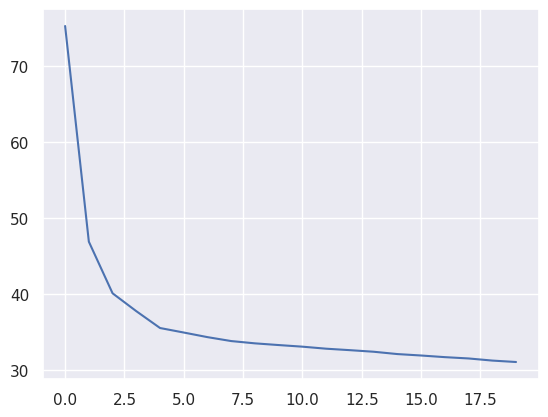

In [115]:
run_all_weeks(copy(args))